# NBA Playoff Predictor Final Project

Beckett Sanderson, Marcos Equiza, Sean Ediger

April 2023

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import copy
import warnings
warnings.simplefilter(action='ignore')

In [2]:
pd.set_option('display.max_columns', None)
ALL_SEASONS = "seasons_data.csv"
CUR_SEASON = "2023_data.csv"

# Read and load all the data

In [3]:
# read in our csv's of data
all_df = pd.read_csv(ALL_SEASONS)
df_23 = pd.read_csv(CUR_SEASON)

# drop minutes played and attendance per game
all_df.drop(['MP', 'Attend./G'], axis=1, inplace=True)
df_23.drop(['MP', 'Attend./G'], axis=1, inplace=True)

# MACHINE LEARNING MODELS

## K-Nearest Neighbor Model

### Split all the data using every attribute

In [4]:
# split the data using all features
features = all_df[all_df.columns[1:-2]]
target = all_df[['Playoff']]

X = features  # get the input features
y = target  # get the target

X_train, X_test, y_train, y_test = train_test_split(X,  # the input features
                                                    y,  # the label
                                                    test_size=0.3,  # set aside 30% of the data as the test set
                                                    random_state=7  # reproduce the results
                                                     )

### Hyperparameter tuning
Identify which k value gets the highest accuracy score

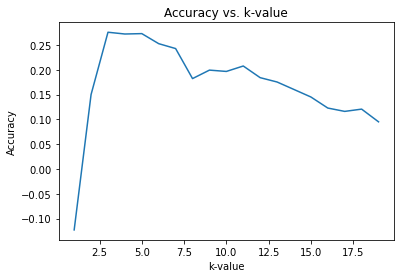

In [5]:
predictions = {}

for k in range(1, 20): #increment k by 2
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions[k] = knn.score(X_test, y_test)
    
sns.lineplot(x=predictions.keys(), y=predictions.values())
plt.title('Accuracy vs. k-value')
plt.xlabel('k-value')
plt.ylabel('Accuracy')
plt.show()    

### Create model with best k-value

In [6]:
#Create the model with n_neighbors = 5
knn = KNeighborsRegressor(n_neighbors = 5) #initialize the classifier and set the number of neighbors

knn.fit(X_train, y_train)
print('The accuracy of the model is: {}'.format(knn.score(X_test, y_test)))

The accuracy of the model is: 0.27305236803671995


In [7]:
# predict the labels for the test set
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse))

The mse of the model is: 0.06363247863247863


### Use the model to predict the outcome of the Playoffs using the current teams

In [8]:
# predict the labels for the 2023 teams
df_23_new = copy.deepcopy(df_23)
teams = df_23.loc[:, 'Team']

df_23_new.drop(['Team', 'Year'], axis=1, inplace=True)
y_pred = knn.predict(df_23_new)

In [9]:
# convert teams to a 2D dataframe with a single column
teams_df = pd.DataFrame({'Team': teams})

# match outcome with team, place in descending order
outcome = pd.concat([teams_df, pd.DataFrame(y_pred, columns=['Playoff'])], axis=1)
outcome.sort_values('Playoff', ascending=False, inplace=True, ignore_index=True)
outcome

,Team,Playoff
0,Cleveland Cavaliers,0.85
1,Boston Celtics,0.45
2,Portland Trail Blazers,0.45
3,New York Knicks,0.45
4,Milwaukee Bucks,0.40
5,Los Angeles Clippers,0.40
6,Phoenix Suns,0.35
7,Toronto Raptors,0.30
8,Sacramento Kings,0.30
9,Washington Wizards,0.25


# Random Forest Model

### Split all the data using every attribute

In [10]:
# split the data using all features
features = all_df[all_df.columns[1:-2]]
target = all_df[['Playoff']]

X = features  # get the input features
y = target  # get the target

X_train, X_test, y_train, y_test = train_test_split(X,  # the input features
                                                    y,  # the label
                                                    test_size=0.3,  # set aside 30% of the data as the test set
                                                    random_state=7  # reproduce the results
                                                     )

### Hyperparameter tuning
Determine what number of bins makes the model work best

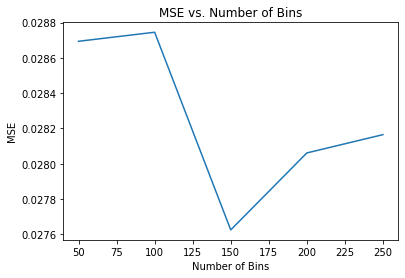

In [11]:
predictions = {}

# test n_estimators [50, 100, 150, 200, 250]
for n in range(50, 300, 50):
    # build model
    rf = RandomForestRegressor(random_state=7, n_estimators=n)
    rf.fit(X_train, y_train)
    
    #predict the labels for the test set
    y_pred   = rf.predict(X_test)
    
    # calculate mse and store 
    mse = mean_squared_error(y_test, y_pred)
    predictions[n] = mse

# Plot mse
sns.lineplot(x=predictions.keys(), y=predictions.values())
plt.title('MSE vs. Number of Bins')
plt.xlabel('Number of Bins')
plt.ylabel('MSE')
plt.show()      

### Create model with best number of bins (using every attribute)

In [12]:
# make random forest regressor model with all features
rf = RandomForestRegressor(random_state=7, n_estimators=150)
rf.fit(X_train, y_train)

# predict the labels for the test set
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse))

The mse of the model is: 0.027625047483380818


### Determine feature importance

In [13]:
# Determine feature importance, identify features
importances = pd.DataFrame({'stat': features.columns,
                            'value': rf.feature_importances_})
importances.sort_values('value', ascending=False, inplace=True)
importances.head()

,stat,value
33,win_perc,0.654893
14,PL,0.028755
15,MOV,0.028665
16,SOS,0.028402
20,NRtg,0.019053


### Make model using top attributes from past model

In [14]:
# split the data with top 10 features
features = all_df[importances.loc[:11, 'stat']]
target = all_df[['Playoff']]

X = features  # get the input features
y = target  # get the target

X_train, X_test, y_train, y_test = train_test_split(X,  # the input features
                                                    y,  # the label
                                                    test_size=0.3,  # set aside 30% of the data as the test set
                                                    random_state=7  # reproduce the results
                                                     )

### Hyperparameter tuning
Determine what number of bins makes the model work best

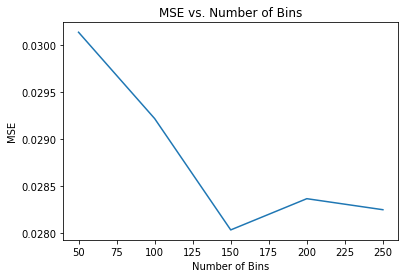

In [15]:
predictions = {}

# test n_estimators [50, 100, 150, 200, 250]
for n in range(50, 300, 50):
    # build model
    rf = RandomForestRegressor(random_state=7, n_estimators=n)
    rf.fit(X_train, y_train)
    
    #predict the labels for the test set
    y_pred   = rf.predict(X_test)
    
    # calculate mse and store 
    mse = mean_squared_error(y_test, y_pred)
    predictions[n] = mse

# Plot mse
sns.lineplot(x=predictions.keys(), y=predictions.values())
plt.title('MSE vs. Number of Bins')
plt.xlabel('Number of Bins')
plt.ylabel('MSE')
plt.show()       

### Create model with best number of bins (using top 10 attributes)

In [16]:
# make random forest regressor model with top 10 features
rf = RandomForestRegressor(random_state=7, n_estimators=150)
rf.fit(X_train, y_train)

# predict the labels for the test set
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# Evaluate the Predictions
print('The mse of the model is: {}'.format(mse))

The mse of the model is: 0.028033072174738837


### Results
This model performs slightly worse than the model using all the attributes (higher MSE).

### Use the model to predict the outcome of the Playoffs using the current teams

In [17]:
# split the data using all features
features = all_df[all_df.columns[1:-2]]
target = all_df[['Playoff']]

X = features  # get the input features
y = target  # get the target

X_train, X_test, y_train, y_test = train_test_split(X,  # the input features
                                                    y,  # the label
                                                    test_size=0.3,  # set aside 30% of the data as the test set
                                                    random_state=7  # reproduce the results
                                                     )

In [18]:
# make random forest regressor model with all features
rf = RandomForestRegressor(random_state=7, n_estimators=150)
rf.fit(X_train, y_train)

# predict the labels for the 2023 teams
df_23_new = copy.deepcopy(df_23)
teams = df_23.loc[:, 'Team']

df_23_new.drop(['Team', 'Year'], axis=1, inplace=True)
y_pred = rf.predict(df_23_new)

In [19]:
# match outcome with team, place in descending order
outcome = pd.DataFrame({'Team': teams,
                        'Playoff': y_pred})
outcome.sort_values('Playoff', ascending=False, inplace=True, ignore_index=True)
outcome

,Team,Playoff
0,Milwaukee Bucks,0.703333
1,Denver Nuggets,0.701667
2,Boston Celtics,0.675000
3,Philadelphia 76ers,0.633333
4,Cleveland Cavaliers,0.631667
5,Memphis Grizzlies,0.540000
6,Sacramento Kings,0.516667
7,Los Angeles Clippers,0.356667
8,Brooklyn Nets,0.350000
9,New York Knicks,0.325000


# Linear Regression Model

Split the data and create the regression

In [20]:
# get target variable
X_train = all_df[all_df.columns[1:-2]]  # all data except team, year, and playoff
y_train = all_df[['Playoff']]

# create the regression and fit it with the data
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [21]:
# find the most impactful variables
coef = reg.coef_.tolist()[0]
variables = list(X_train.columns)
equation = pd.DataFrame({'Label': variables,
                         'Coefficient': coef})
equation.sort_values('Coefficient', ascending=False, inplace=True, ignore_index=True)
print(equation)

             Label  Coefficient
0      fga_perc_2P   100.043844
1             3PAr    57.997617
2      fga_perc_3P    57.997617
3   fga_perc_10-16    22.488994
4    fga_perc_3-10    21.232004
5   fga_perc_16-3P    21.144929
6     fga_perc_0-3    20.600221
7         off_eFG%    16.659959
8       dunks_%FGA    14.493047
9         def_eFG%    12.067231
10             TS%     7.858344
11      fg_perc_2P     2.714960
12             MOV     2.469172
13             SOS     2.394694
14      def_FT/FGA     1.956184
15        win_perc     1.895515
16        off_TOV%     0.561913
17             FT%     0.552078
18     corner_%3PA     0.457436
19             TRB     0.239624
20             AST     0.057424
21             FTA     0.052584
22           Dist.     0.041684
23             STL     0.034538
24             BLK     0.027648
25            NRtg     0.027291
26              PW     0.009856
27              PF     0.005736
28       heave_Md.     0.004787
29              PL     0.003921
30      

In [22]:
# calculate and display the r-squared value
r_sq = round(reg.score(X_train, y_train), 5)
print('\nThe R-Squared is:', r_sq)


The R-Squared is: 0.70766


In [23]:
# run the regression on the data for this year
X_test = df_23[df_23.columns[1:-1]]
y_pred = reg.predict(X_test)

# assign the predictions to the teams and sort
teams = list(df_23.loc[:, 'Team'])
playoff = y_pred.tolist()
predictions = pd.DataFrame({'Team': teams,
                            'Playoff': playoff})
predictions.sort_values('Playoff', ascending=False, inplace=True, ignore_index=True)

print(predictions)

                      Team                 Playoff
0       Philadelphia 76ers    [0.6829325603739989]
1          Milwaukee Bucks    [0.6579364099926153]
2           Boston Celtics    [0.6398766345104718]
3           Denver Nuggets    [0.5609501217847139]
4            Brooklyn Nets    [0.5070675406532388]
5         Sacramento Kings   [0.42888018169327324]
6     Los Angeles Clippers     [0.394160159959867]
7        Memphis Grizzlies    [0.3828956720235652]
8   Minnesota Timberwolves   [0.37771387644505694]
9             Phoenix Suns   [0.36911283973853415]
10   Golden State Warriors   [0.36761946474531726]
11     Cleveland Cavaliers   [0.35640991546296164]
12           Chicago Bulls   [0.29980168793055384]
13              Miami Heat   [0.29348295871660923]
14      Los Angeles Lakers    [0.2568247811471025]
15         New York Knicks   [0.23476363969734848]
16  Portland Trail Blazers   [0.20641626130054647]
17          Indiana Pacers   [0.20582612427256208]
18    New Orleans Pelicans   [0